1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)
df.index.name = "Index"

In [7]:
df.columns

Index([u'default', u'student', u'balance', u'income'], dtype='object')

2) Convert `default` and `student` to categorical variables.

In [3]:
y_default = np.array(df["default"] == "Yes",dtype=int)
y_student = np.array(df["student"] == "Yes",dtype=int)


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

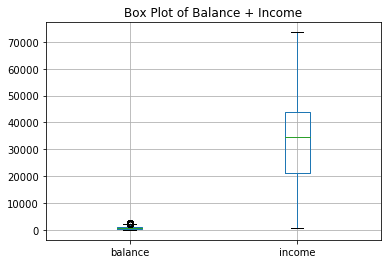

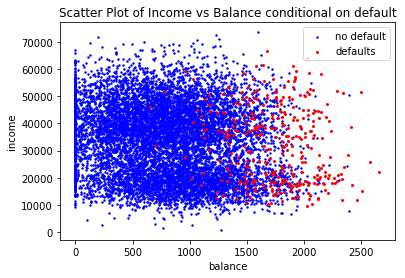

In [4]:
df.boxplot()
plt.title("Box Plot of Balance + Income")
plt.show()

plt.scatter(df.loc[df["default"]=="No","balance"],df.loc[df["default"]=="No","income"],color="blue",label="no default",s=2)
plt.scatter(df.loc[df["default"]=="Yes","balance"],df.loc[df["default"]=="Yes","income"],color="red",label="defaults",s=4)
plt.xlabel("balance")
plt.ylabel("income")
plt.title("Scatter Plot of Income vs Balance conditional on default")
plt.legend(loc="best")
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

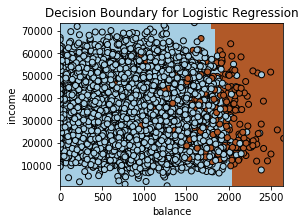

In [63]:
from sklearn.linear_model import LogisticRegression

logreg  = LogisticRegression(fit_intercept=True,penalty="l1")
# X = np.array(df.loc[df["student"]=="Yes",["balance","income"]],dtype=float)
# y = np.array(df.loc[df["student"]=="Yes","default"]=="Yes",dtype=float)
X = np.array(df[["balance","income"]],dtype=float)
y = np.array(df["default"]=="Yes",dtype=int)

logreg.fit(X,y)

h = 50

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min()-1.0, X[:, 0].max()+1.0
y_min, y_max = X[:, 1].min()-1.0, X[:, 1].max()+1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('balance')
plt.ylabel('income')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary for Logistic Regression")

plt.show()

Area under the ROC curve : 0.960835


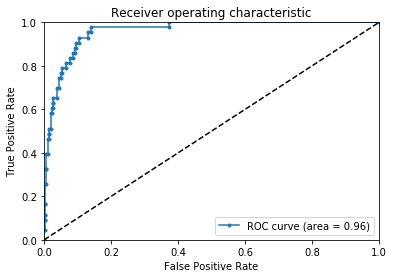

In [42]:
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,silent,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    if not silent:
        print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,False, C=1.0,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

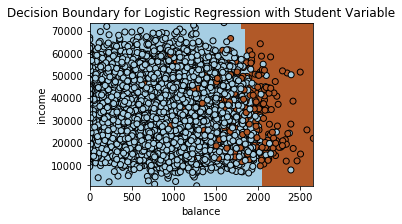

Area under the ROC curve : 0.960878


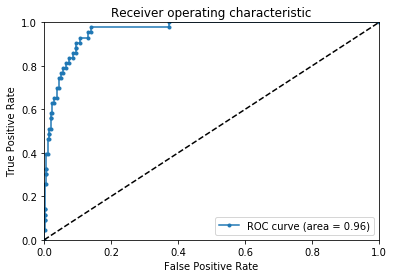

In [81]:
y = pd.get_dummies(df["default"])
y = y["Yes"]
y.name = "default"

df_student = pd.get_dummies(df["student"])
df_student.name = "student"
df_student = df_student["Yes"]
df_student.name = "student"

df_final = df[["balance","income"]].copy()
df_final = df_final.join(df_student)
df_final.head()

logreg2  = LogisticRegression(fit_intercept=True,penalty="l1")
logreg2.fit(df_final,y)

h = 50

X = np.array(df_final[["balance","income"]],dtype=float)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min()-1.0, X[:, 0].max()+1.0
y_min, y_max = X[:, 1].min()-1.0, X[:, 1].max()+1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('balance')
plt.ylabel('income')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary for Logistic Regression with Student Variable")

plt.show()

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,False,C=1.0,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

Performance seems to be the same with the added variable of "student".

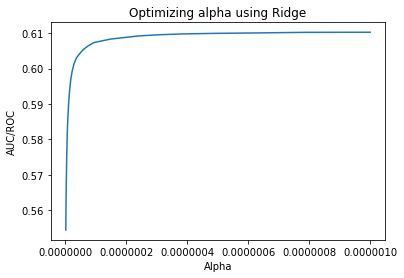

Alpha Best : 0.000001


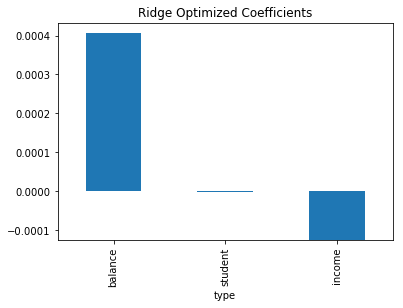

In [91]:
# Create linear regression object
alphas = np.logspace(-9,-6,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l2')

    # Train the model using the training sets
    #regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(df_final,y,LogisticRegression,True,C=alpha,penalty='l2')
    scores.append(roc_auc)
plt.plot(alphas,scores)
plt.xlabel("Alpha")
plt.ylabel("AUC/ROC")
plt.title("Optimizing alpha using Ridge")
plt.show()

alpha_best = alphas[np.argmax(scores)]
print "Alpha Best : %f" % alpha_best

regr = LogisticRegression(C=alpha,penalty='l2')

# Train the model using the training sets
regr.fit(df_final,y)
dfCoeffs = pd.DataFrame({'type':df_final.columns.values, 'coef':regr.coef_[0]})


dfCoeffs2 = dfCoeffs.groupby('type')['coef'].mean()

dfCoeffs2 = dfCoeffs2.sort_values()
dfCoeffs2[::-1].plot(kind='bar',title="Ridge Optimized Coefficients")
plt.show()

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

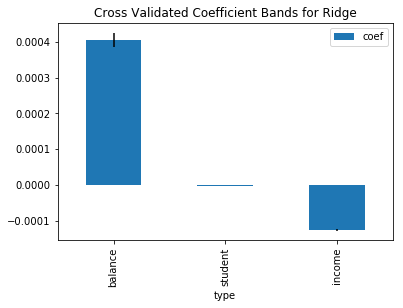

In [118]:
from sklearn.cross_validation import KFold

#y.head()

def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=False)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        #print clf.coef_[0]
        coeffs.append(clf.coef_)
    return coeffs

coeffs=run_cv_coeffs(df_final.values,y.values,LogisticRegression,C=alpha_best,penalty='l2')

def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][0][i] + coeffs[1][0][i] + coeffs[2][0][i] + coeffs[3][0][i] + coeffs[4][0][i])/5 for i in range(0,len(df_final.columns))]
    coeffs_std = [np.std([coeffs[0][0][i],coeffs[1][0][i],coeffs[2][0][i],coeffs[3][0][i],coeffs[4][0][i]]) for i in range(0,len(df_final.columns))]
    return coeffs_avgd, coeffs_std

coeffs_avg,coeffs_std=get_coeffs(coeffs)
dfCoeffs = pd.DataFrame({'type':df_final.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})


dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values

dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals)
plt.title("Cross Validated Coefficient Bands for Ridge")
plt.show()

As you can see, the "student" variable does not have any explanatory power.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC. 